# Imports

In [35]:
# Allow importing items in src folder
import sys

SCRIPT_DIR = "/home/shane/Projects/sign_data"
sys.path.append(SCRIPT_DIR)

In [36]:
import matplotlib.pyplot as plt
import mediapipe as mp

In [37]:
from cv2 import VideoCapture, cvtColor, COLOR_RGB2BGR, putText, imshow, FONT_HERSHEY_SIMPLEX, destroyAllWindows, waitKey
from torch import tensor, empty, cat, float64

In [38]:
from src.files import read_from_file, check_file_exists, load_pickle
from src.inference import process_frame, plot_hand_coords, get_prediction, detokenise
from src.models import load_model_from_hub
from src.data.text_variables import *

# Variables

In [39]:
# File Paths
model_file = "../trained_models/stream_resnet34_20220430.pt"
normalization_stats_file = "../trained_models/normalization_stats_mhwl.pkl"
vocab_file = "../vocab.csv"
video_file = "../videos/Alphabet01.mp4"

In [40]:
# Model Variables
model_name = 'resnet34'
frames_per_sign = 30
no_coords = 126

# Video Variables
frame_number = 6000

# Mediapipe Variables
hand_confidence = 0.5
static_image_mode = True
max_hands = 2

In [41]:
check_file_exists(video_file)

# Load Normalization Stats

In [42]:
normalization_stats = load_pickle(normalization_stats_file)
mean = tensor(normalization_stats[0]).repeat(3, 1, 1)
std = tensor(normalization_stats[1]).repeat(3, 1, 1)

# Load Vocab

In [43]:
vocab = read_from_file(vocab_file)

# Load Video Frame

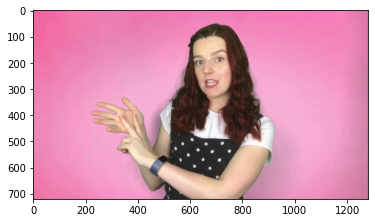

In [44]:
video = VideoCapture(video_file)
if video.isOpened():
    video.set(1,frame_number)
    success, frame = video.read()
    if success:
        plt.imshow(cvtColor(frame, COLOR_RGB2BGR))

# Get Mediapipe Output

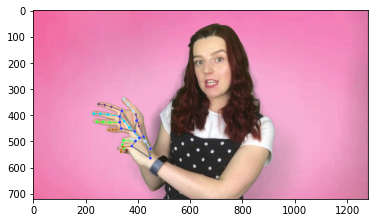

In [45]:
with mp.solutions. \
        hands.Hands(static_image_mode=static_image_mode,
                    max_num_hands=max_hands,
                    min_detection_confidence=hand_confidence) as hands:
    # Data has been normlized and converted to tensor. mp_result is for debugging.
    data, mp_result = process_frame(hands, frame, mean, std, debug=True)
    frame = plot_hand_coords(mp_result, frame)
    plt.imshow(frame)

# Load Model

In [46]:
model = load_model_from_hub(model_name, model_file)

Using cache found in /home/shane/.cache/torch/hub/pytorch_vision_v0.10.0


# Create data for model

In [47]:
cur_sign = empty((3, frames_per_sign, no_coords), dtype=float64)
cur_sign = cat((cur_sign[:, 1:, :], data), dim=1)

# Make prediction from data

In [48]:
pred = get_prediction(cur_sign, model)
sign = detokenise(vocab, pred)

In [49]:
sign

['c']

# Plot prediction onto Image

In [50]:
putText(frame, sign[0], bottomLeftCornerOfText, font,
                fontScale, fontColor, thickness, lineType)
imshow("Frame {} from {}".format(frame_number, video_file), cvtColor(frame, COLOR_RGB2BGR))
# Press any key on keyboard to exit
waitKey(0)
destroyAllWindows()